In [57]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [59]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [60]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [61]:
tf.keras.backend.clear_session()

In [62]:
subject = 'Rio De Janeiro - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [63]:
data = pd.read_csv('2003_mo_model_input_RJ.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Rio De Janeiro - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
0,2003-1,0.291137,12454.864800,3.675288e+07,254.362,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512
1,2003-2,0.293538,12574.990185,3.674675e+07,252.842,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332
2,2003-3,0.295914,12687.426111,3.674063e+07,229.385,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152
3,2003-4,0.298264,12814.530039,3.673451e+07,243.407,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971
4,2003-5,0.300588,12915.463832,3.672839e+07,256.535,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,41155.899192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,41127.312621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,41085.437504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,40981.162673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


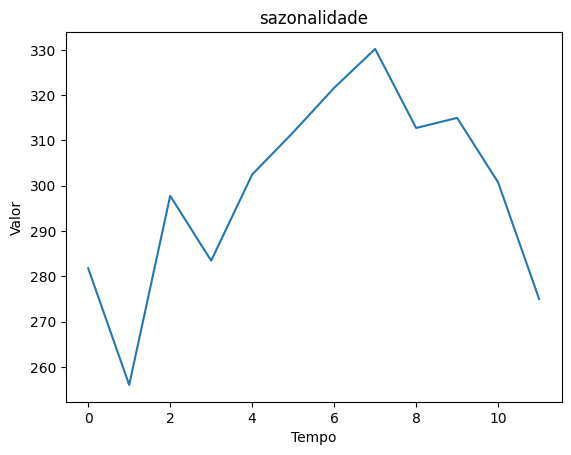

,sazonalidade
sazonalidade,
0,281.787783
1,256.037383
2,297.774940
3,283.460373
4,302.478384
5,311.794884
6,321.608097
7,330.208811
8,312.754725


In [64]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [65]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego,sazonalidade,Rio De Janeiro - Consumo de Cimento (t)
0,2003-1,0.291137,12454.864800,3.675288e+07,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512,281.787783,254.362
1,2003-2,0.293538,12574.990185,3.674675e+07,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332,256.037383,252.842
2,2003-3,0.295914,12687.426111,3.674063e+07,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152,297.774940,229.385
3,2003-4,0.298264,12814.530039,3.673451e+07,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971,283.460373,243.407
4,2003-5,0.300588,12915.463832,3.672839e+07,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791,302.478384,256.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,41155.899192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.478384,NaN
245,2023-6,NaN,41127.312621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.794884,NaN
246,2023-7,NaN,41085.437504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321.608097,NaN
247,2023-8,NaN,40981.162673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330.208811,NaN


In [66]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      246.602
1      237.093
2      270.163
3      263.941
4      273.825
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 249, dtype: float64

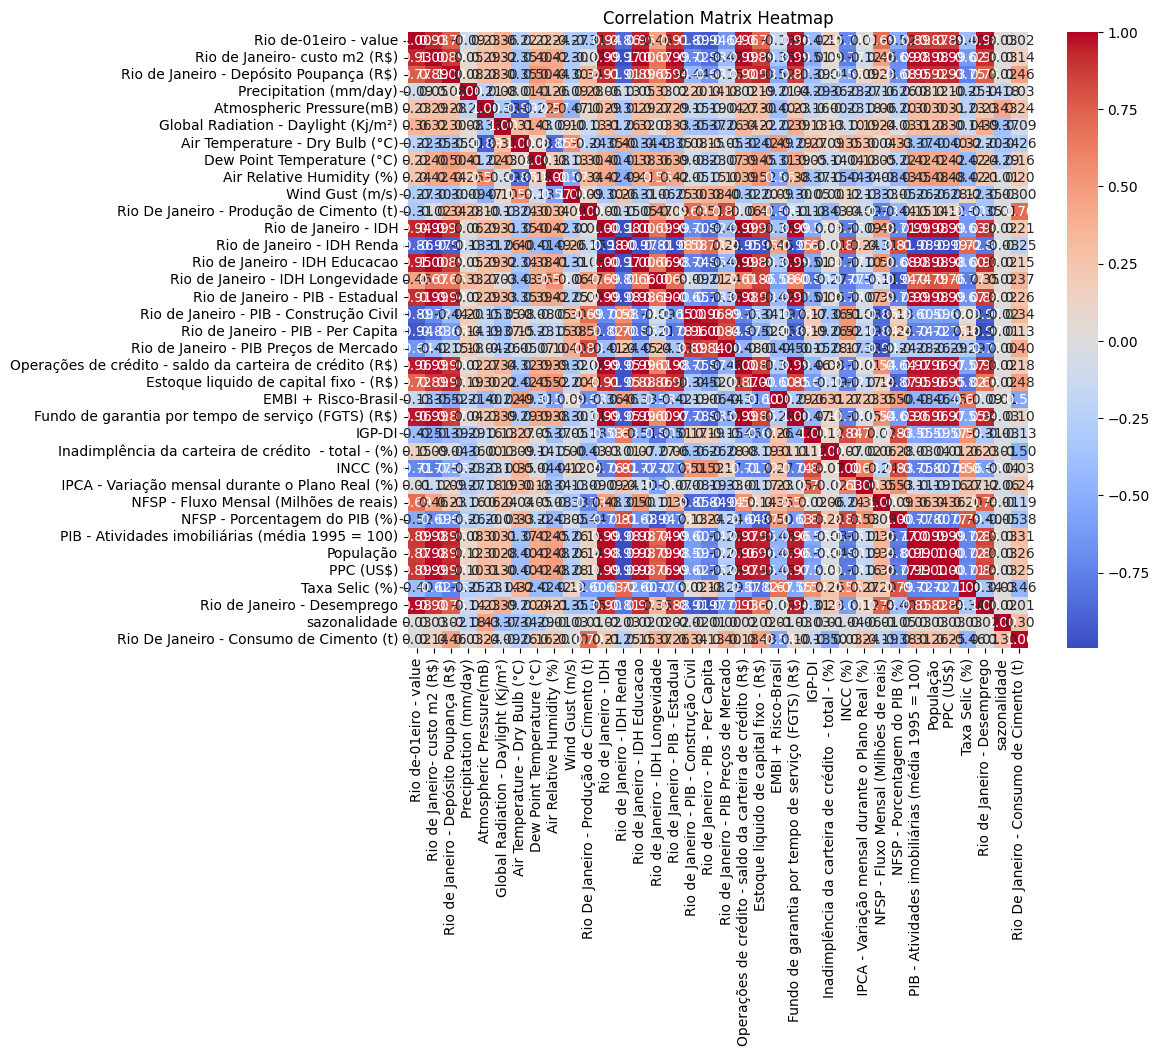

In [67]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [69]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio de-01eiro - value,7.181590e+03
1,Rio de Janeiro- custo m2 (R$),1.421541e+05
2,Rio de Janeiro - Depósito Poupança (R$),7.305485e+03
3,Precipitation (mm/day),5.704102e+00
4,Atmospheric Pressure(mB),4.252838e+01
5,Global Radiation - Daylight (Kj/m²),8.159296e+00
6,Air Temperature - Dry Bulb (°C),1.197714e+02
7,Dew Point Temperature (°C),3.791324e+01
8,Air Relative Humidity (%),5.933054e+01
9,Wind Gust (m/s),9.873558e+00


In [70]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)',
                 'PPC (US$)',
                 'População',
                 'Rio de Janeiro- custo m2 (R$)',
                 'Rio de Janeiro - Depósito Poupança (R$)', 
                 'sazonalidade'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 0


,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego,sazonalidade
0,0.291137,12454.864800,3.675288e+07,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512,281.787783
1,0.293538,12574.990185,3.674675e+07,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332,256.037383
2,0.295914,12687.426111,3.674063e+07,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152,297.774940
3,0.298264,12814.530039,3.673451e+07,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971,283.460373
4,0.300588,12915.463832,3.672839e+07,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791,302.478384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.440386,28369.283457,5.778569e+07,1.410990,1014.918407,1218.552061,20.889431,16.857232,81.759014,0.758575,200.661356,0.783899,0.769082,0.764230,0.818689,4.120500e+08,1.730116e+07,21.873489,3.478366e+08,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,12.640247,330.208811
176,0.441421,28455.574266,5.795774e+07,1.498089,1013.640126,1264.645977,21.802358,17.600132,81.096566,0.791856,201.758628,0.783847,0.769140,0.764246,0.818406,4.120803e+08,1.730238e+07,21.876366,3.478862e+08,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,12.627623,312.754725
177,0.442063,28544.256177,5.812978e+07,1.835601,1012.127015,1241.248230,22.610954,18.602197,81.916837,0.812112,203.004428,0.783796,0.769198,0.764262,0.81812

In [71]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
0,-1.589585,-1.316081,0.753700,-0.831104,2.055830,0.922951,1.216253,-0.093590,-3.716418,-1.075959,-1.657615,2.080285,-1.540220,-3.035607,-1.736304,0.028239,0.034039,-1.517183,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-0.723972
1,-1.565148,-1.316690,0.205695,-0.254000,1.823027,0.500845,0.792722,-0.123693,-2.693718,-1.093934,-1.640980,2.048050,-1.527426,-2.955313,-1.713787,0.041861,0.065861,-1.437199,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.727178
2,-1.542276,-1.317299,-0.192845,0.137696,0.752891,0.060379,0.529821,0.063728,-1.938001,-1.086614,-1.624345,2.015816,-1.514632,-2.875019,-1.691271,0.055484,0.097683,-1.357215,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.730385
3,-1.516419,-1.317908,-0.357715,0.600215,0.465838,-0.267306,0.183871,0.029735,-1.359602,-1.087290,-1.607711,1.983581,-1.501838,-2.794725,-1.668755,0.069107,0.129506,-1.277232,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.733591
4,-1.495886,-1.318516,-0.694670,1.094982,-0.217222,-0.712077,-0.258612,0.013202,-0.888504,-1.088409,-1.591076,1.951347,-1.489044,-2.714431,-1.646238,0.082729,0.161328,-1.197248,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.736797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.647848,0.775945,-0.573719,1.132401,0.553646,-1.084402,-0.441122,0.452658,-0.586828,-1.021286,1.290430,-1.293375,1.529907,0.269780,1.278435,-1.953470,-1.527378,-1.152301,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.498411
176,1.665402,0.793058,-0.492193,0.560510,0.994095,-0.707248,-0.144227,0.361745,-0.368766,-0.983319,1.275962,-1.287928,1.531394,0.205440,1.280134,-1.950582,-1.510755,-1.119545,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,1.491862
177,1.683442,0.810170,-0.176279,-0.116443,0.770519,-0.373196,0.256241,0.474317,-0.236047,-0.940213,1.261493,-1.282482,1.532881,0.141099,1.281834,-1.947695,-1.494133,-1.086790,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.485312
178,1.701681,0.827282,0.038890,-0.508223,0.783910,-0.187744,0.563272,0.588016,-0.298803,-0.886283,1.247025,-1.277035,1.534368,0.076758,1.283534,-1.944807,-1.477510,-1.054035,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,1.47

In [72]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
0,-1.589585,-1.316081,0.753700,-0.831104,2.055830,0.922951,1.216253,-0.093590,-3.716418,-1.075959,-1.657615,2.080285,-1.540220,-3.035607,-1.736304,0.028239,0.034039,-1.517183,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-0.723972
1,-1.565148,-1.316690,0.205695,-0.254000,1.823027,0.500845,0.792722,-0.123693,-2.693718,-1.093934,-1.640980,2.048050,-1.527426,-2.955313,-1.713787,0.041861,0.065861,-1.437199,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.727178
2,-1.542276,-1.317299,-0.192845,0.137696,0.752891,0.060379,0.529821,0.063728,-1.938001,-1.086614,-1.624345,2.015816,-1.514632,-2.875019,-1.691271,0.055484,0.097683,-1.357215,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.730385
3,-1.516419,-1.317908,-0.357715,0.600215,0.465838,-0.267306,0.183871,0.029735,-1.359602,-1.087290,-1.607711,1.983581,-1.501838,-2.794725,-1.668755,0.069107,0.129506,-1.277232,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.733591
4,-1.495886,-1.318516,-0.694670,1.094982,-0.217222,-0.712077,-0.258612,0.013202,-0.888504,-1.088409,-1.591076,1.951347,-1.489044,-2.714431,-1.646238,0.082729,0.161328,-1.197248,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.736797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.435261,0.597883,-0.407025,0.840531,-0.299455,-0.904556,-0.283916,0.284953,-0.277659,-1.578000,1.438357,-1.366225,1.496590,0.975564,1.230749,-1.859723,-1.715332,-1.555902,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.573898
164,1.451557,0.609538,-0.159694,0.393261,0.223344,-0.595608,-0.013160,0.244627,-0.045512,-1.567412,1.429027,-1.359280,1.501172,0.924485,1.237906,-1.882515,-1.701013,-1.521039,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,1.567970
165,1.468108,0.621193,0.430992,-0.126329,1.062230,-0.220083,0.301235,0.185357,0.186463,-1.546446,1.419698,-1.352336,1.505754,0.873405,1.245064,-1.905307,-1.686694,-1.486176,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.562041
166,1.484727,0.632848,0.942915,-0.460305,1.923341,0.089680,0.529347,0.101566,0.267462,-1.540677,1.410368,-1.345392,1.510335,0.822325,1.252222,-1.928098,-1.672375,-1.451313,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,1.556113


In [73]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      246.602
1      237.093
2      270.163
3      263.941
4      273.825
        ...   
163    229.696
164    232.624
165    234.262
166    217.727
167    190.769
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 168, dtype: float64

In [74]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [75]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 33)

In [76]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
132,0.829638,1.537840,-0.107407,-0.469265,2.344339,0.615316,0.925522,0.012417,-0.494855,0.526952,1.017661,-0.751430,0.916984,0.124057,1.030909,-0.499971,-0.821387,-0.336565,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,1.062719
133,0.850852,1.490378,-0.172203,-0.271371,1.491964,0.333844,0.750272,0.148866,-0.839924,0.472088,1.023434,-0.739806,0.930900,0.084637,1.036501,-0.561922,-0.882088,-0.430701,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,1.091726
134,0.871803,1.442917,-0.242564,0.267696,1.034971,0.191340,0.487758,-0.109705,-0.787323,0.393945,1.029206,-0.728183,0.944816,0.045216,1.042092,-0.623872,-0.942788,-0.524837,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,1.120733
135,0.891571,1.395455,-0.353986,1.005155,0.101090,-0.010249,0.060570,-0.467362,-0.999492,0.313726,1.034979,-0.716560,0.958732,0.005796,1.047684,-0.685822,-1.003488,-0.618973,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,1.149740
136,0.911287,1.347994,-0.515395,1.480063,-0.349889,-0.308647,-0.325422,-0.609095,-0.854763,0.232099,1.040752,-0.704936,0.972649,-0.033625,1.053276,-0.747773,-1.064189,-0.713109,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,1.178747
137,0.932476,1.300532,-0.515365,1.721858,-0.152061,-0.316643,-0.534267,-0.899194,-0.386304,0.148612,1.046525,-0.693313,0.986565,-0.073046,1.058868,-0.809723,-1.124889,-0.807245,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,1.207753
138,0.953606,1.253071,-0.449282,1.685153,0.016228,-0.490179,-0.578300,-0.675998,-0.290788,0.063609,1.052298,-0.681690,1.000481,-0.112466,1.064460,-0.871673,-1.185590,-0.901381,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,1.236760
139,0.974603,1.205609,-0.417413,0.963027,0.639227,-0.479406,-0.388749,-0.403120,0.042338,-0.023004,1.058070,-0.670066,1.014397,-0.151887,1.070052,-0.933624,-1.246290,-0.995517,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,1.265767
140,0.995220,1.158148,-0.290402,0.230492,1.487184,-0.107610,-0.113127,-0.514438,0.318444,-0.110768,1.063843,-0.658443,1.028313,-0.191307,1.075644,-0.995574,-1.306990,-1.089653,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,1.294774
141,1.015437,1.110686,0.124783,-0.441616,1.951812,0.223756,0.215847,-0.481187,0.339356,-0.199731,1.069616,-0.646820,1.042229,-0.230728,1.081235,-1.0

In [77]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 33)

In [78]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [79]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [80]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [81]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[4190640025, 827936540, 466429470, 3430380239, 1720871684, 3040961961, 3815279812, 1511193548, 202423044, 3003771045]


Step: 0 ___________________________________________
val_loss: 1454.04443359375
winner_seed: 4190640025


Step: 1 ___________________________________________
val_loss: 555.7710571289062
winner_seed: 827936540


Step: 2 ___________________________________________
val_loss: 682.8132934570312


Step: 3 ___________________________________________
val_loss: 1287.203369140625


Step: 4 ___________________________________________
val_loss: 1378.5703125


Step: 5 ___________________________________________
val_loss: 48414916608.0


Step: 6 ___________________________________________
val_loss: 573.8153076171875


Step: 7 ___________________________________________
val_loss: 435.52490234375
winner_seed: 1511193548


Step: 8 ___________________________________________
val_loss: 1537.1173095703125


Step: 9 ___________________________________________
val_loss: 555.9390258789062




In [82]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 129ms/step - loss: 75071.1797 - val_loss: 27128.4434
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 6204.9766 - val_loss: 17560.3086
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 5755.9028 - val_loss: 19820.5391
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 5930.1309 - val_loss: 12716.1582
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 6210.5591 - val_loss: 22355.8477
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 5875.9683 - val_loss: 15928.4033
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 6780.8442 - val_loss: 13399.5000
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 5810.0547 - val_loss: 16044.7637
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 5922.7256 - val_loss: 14821.0703
Epoch 10/10000
4/4 [===============

Epoch 78/10000
4/4 [==============================] - 0s 10ms/step - loss: 472.8619 - val_loss: 1590.3264
Epoch 79/10000
4/4 [==============================] - 0s 10ms/step - loss: 427.7239 - val_loss: 1247.9292
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 429.6516 - val_loss: 1338.7349
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 408.3928 - val_loss: 1600.3414
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 581.6973 - val_loss: 1534.2113
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 606.1541 - val_loss: 1463.9783
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 469.5406 - val_loss: 1462.4238
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 530.7479 - val_loss: 1233.5812
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 577.5834 - val_loss: 1228.0923
Epoch 87/10000
4/4 [==========================

Epoch 155/10000
4/4 [==============================] - 0s 12ms/step - loss: 422.1788 - val_loss: 967.3215
Epoch 156/10000
4/4 [==============================] - 0s 11ms/step - loss: 375.4096 - val_loss: 793.6682
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 359.0865 - val_loss: 1463.1881
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 310.6700 - val_loss: 684.6599
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 350.7746 - val_loss: 1473.0248
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 316.7973 - val_loss: 1411.0966
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 450.0001 - val_loss: 1700.3596
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 289.9121 - val_loss: 1420.4226
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 280.4942 - val_loss: 1488.6281
Epoch 164/10000
4/4 [===================

4/4 [==============================] - 0s 11ms/step - loss: 191.5092 - val_loss: 1315.8663
Epoch 232/10000
4/4 [==============================] - 0s 11ms/step - loss: 207.0464 - val_loss: 1413.7429
Epoch 233/10000
4/4 [==============================] - 0s 11ms/step - loss: 325.2739 - val_loss: 1553.2444
Epoch 234/10000
4/4 [==============================] - 0s 11ms/step - loss: 236.6840 - val_loss: 1447.8534
Epoch 235/10000
4/4 [==============================] - 0s 10ms/step - loss: 234.6120 - val_loss: 1410.5591
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 211.6528 - val_loss: 1460.4354
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 196.7243 - val_loss: 1438.0370
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 222.8283 - val_loss: 1640.2390
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 246.8570 - val_loss: 1399.1542
Epoch 240/10000
4/4 [==============================] 

4/4 [==============================] - 0s 10ms/step - loss: 173.2990 - val_loss: 1174.2107
Epoch 308/10000
4/4 [==============================] - 0s 11ms/step - loss: 251.8652 - val_loss: 1226.8712
Epoch 309/10000
4/4 [==============================] - 0s 11ms/step - loss: 180.0680 - val_loss: 1449.5337
Epoch 310/10000
4/4 [==============================] - 0s 12ms/step - loss: 164.1671 - val_loss: 1679.9922
Epoch 311/10000
4/4 [==============================] - 0s 10ms/step - loss: 161.7132 - val_loss: 1285.1077
Epoch 312/10000
4/4 [==============================] - 0s 10ms/step - loss: 151.4162 - val_loss: 1351.7876
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 153.8821 - val_loss: 1348.8198
Epoch 314/10000
4/4 [==============================] - 0s 11ms/step - loss: 148.4414 - val_loss: 1031.8125
Epoch 315/10000
4/4 [==============================] - 0s 10ms/step - loss: 182.1883 - val_loss: 1399.9806
Epoch 316/10000
4/4 [==============================] 

4/4 [==============================] - 0s 10ms/step - loss: 153.1017 - val_loss: 996.0724
Epoch 384/10000
4/4 [==============================] - 0s 12ms/step - loss: 184.8123 - val_loss: 1258.6163
Epoch 385/10000
4/4 [==============================] - 0s 10ms/step - loss: 151.9153 - val_loss: 1162.3448
Epoch 386/10000
4/4 [==============================] - 0s 11ms/step - loss: 139.2382 - val_loss: 1496.6223
Epoch 387/10000
4/4 [==============================] - 0s 11ms/step - loss: 161.8760 - val_loss: 1108.2683
Epoch 388/10000
4/4 [==============================] - 0s 11ms/step - loss: 151.3841 - val_loss: 1548.5229
Epoch 389/10000
4/4 [==============================] - 0s 11ms/step - loss: 173.1682 - val_loss: 1384.6953
Epoch 390/10000
4/4 [==============================] - 0s 11ms/step - loss: 169.2831 - val_loss: 980.9076
Epoch 391/10000
4/4 [==============================] - 0s 11ms/step - loss: 166.3749 - val_loss: 1298.2372
Epoch 392/10000
4/4 [==============================] - 

Epoch 460/10000
4/4 [==============================] - 0s 12ms/step - loss: 127.8641 - val_loss: 1351.6565
Epoch 461/10000
4/4 [==============================] - 0s 10ms/step - loss: 127.5765 - val_loss: 1114.2275
Epoch 462/10000
4/4 [==============================] - 0s 10ms/step - loss: 137.7830 - val_loss: 1237.7705
Epoch 463/10000
4/4 [==============================] - 0s 11ms/step - loss: 141.5215 - val_loss: 1171.3704
Epoch 464/10000
4/4 [==============================] - 0s 10ms/step - loss: 149.3423 - val_loss: 1409.7222
Epoch 465/10000
4/4 [==============================] - 0s 10ms/step - loss: 165.1000 - val_loss: 1219.0342
Epoch 466/10000
4/4 [==============================] - 0s 10ms/step - loss: 134.5357 - val_loss: 1041.4456
Epoch 467/10000
4/4 [==============================] - 0s 11ms/step - loss: 137.1166 - val_loss: 1126.5876
Epoch 468/10000
4/4 [==============================] - 0s 10ms/step - loss: 134.1138 - val_loss: 1203.3529
Epoch 469/10000
4/4 [================

4/4 [==============================] - 0s 11ms/step - loss: 114.6670 - val_loss: 1240.5286
Epoch 537/10000
4/4 [==============================] - 0s 11ms/step - loss: 115.7095 - val_loss: 1153.9460
Epoch 538/10000
4/4 [==============================] - 0s 12ms/step - loss: 106.7270 - val_loss: 1272.5918
Epoch 539/10000
4/4 [==============================] - 0s 14ms/step - loss: 110.9320 - val_loss: 954.0522
Epoch 540/10000
4/4 [==============================] - 0s 11ms/step - loss: 115.0861 - val_loss: 1017.6071
Epoch 541/10000
4/4 [==============================] - 0s 10ms/step - loss: 114.2953 - val_loss: 1079.4142
Epoch 542/10000
4/4 [==============================] - 0s 10ms/step - loss: 139.1850 - val_loss: 1263.4900
Epoch 543/10000
4/4 [==============================] - 0s 10ms/step - loss: 121.7325 - val_loss: 816.2908
Epoch 544/10000
4/4 [==============================] - 0s 10ms/step - loss: 120.8473 - val_loss: 867.4520
Epoch 545/10000
4/4 [==============================] - 0

Epoch 613/10000
4/4 [==============================] - 0s 13ms/step - loss: 97.2784 - val_loss: 1046.0702
Epoch 614/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.0555 - val_loss: 1458.8408
Epoch 615/10000
4/4 [==============================] - 0s 12ms/step - loss: 103.5849 - val_loss: 1399.3154
Epoch 616/10000
4/4 [==============================] - 0s 10ms/step - loss: 102.9868 - val_loss: 1113.6963
Epoch 617/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.4269 - val_loss: 1159.8740
Epoch 618/10000
4/4 [==============================] - 0s 11ms/step - loss: 102.9843 - val_loss: 1362.0015
Epoch 619/10000
4/4 [==============================] - 0s 12ms/step - loss: 118.2440 - val_loss: 1180.1654
Epoch 620/10000
4/4 [==============================] - 0s 10ms/step - loss: 101.9699 - val_loss: 1188.0219
Epoch 621/10000
4/4 [==============================] - 0s 10ms/step - loss: 107.2345 - val_loss: 1224.4396
Epoch 622/10000
4/4 [==================

4/4 [==============================] - 0s 10ms/step - loss: 99.2393 - val_loss: 1084.5155
Epoch 691/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.3378 - val_loss: 1264.2992
Epoch 692/10000
4/4 [==============================] - 0s 9ms/step - loss: 141.3223 - val_loss: 1824.9814
Epoch 693/10000
4/4 [==============================] - 0s 10ms/step - loss: 99.0995 - val_loss: 1188.1379
Epoch 694/10000
4/4 [==============================] - 0s 9ms/step - loss: 118.6344 - val_loss: 1248.3436
Epoch 695/10000
4/4 [==============================] - 0s 9ms/step - loss: 167.7057 - val_loss: 1566.3275
Epoch 696/10000
4/4 [==============================] - 0s 9ms/step - loss: 133.7260 - val_loss: 857.7335
Epoch 697/10000
4/4 [==============================] - 0s 9ms/step - loss: 99.0227 - val_loss: 1237.5771
Epoch 698/10000
4/4 [==============================] - 0s 14ms/step - loss: 85.9057 - val_loss: 1020.6229
Epoch 699/10000
4/4 [==============================] - 0s 10ms/s

4/4 [==============================] - 0s 10ms/step - loss: 97.6893 - val_loss: 1120.8159
Epoch 768/10000
4/4 [==============================] - 0s 10ms/step - loss: 87.7243 - val_loss: 826.5266
Epoch 769/10000
4/4 [==============================] - 0s 11ms/step - loss: 88.9840 - val_loss: 900.6017
Epoch 770/10000
4/4 [==============================] - 0s 10ms/step - loss: 85.4857 - val_loss: 974.6271
Epoch 771/10000
4/4 [==============================] - 0s 10ms/step - loss: 91.3918 - val_loss: 1210.0961
Epoch 772/10000
4/4 [==============================] - 0s 10ms/step - loss: 87.9829 - val_loss: 1290.4561
Epoch 773/10000
4/4 [==============================] - 0s 10ms/step - loss: 86.5380 - val_loss: 1098.2256
Epoch 774/10000
4/4 [==============================] - 0s 10ms/step - loss: 73.8782 - val_loss: 989.9258
Epoch 775/10000
4/4 [==============================] - 0s 11ms/step - loss: 81.0280 - val_loss: 1022.1866
Epoch 776/10000
4/4 [==============================] - 0s 11ms/ste

Epoch 845/10000
4/4 [==============================] - 0s 10ms/step - loss: 79.1625 - val_loss: 932.4206
Epoch 846/10000
4/4 [==============================] - 0s 10ms/step - loss: 83.3755 - val_loss: 850.8952
Epoch 847/10000
4/4 [==============================] - 0s 11ms/step - loss: 95.8117 - val_loss: 738.6147
Epoch 848/10000
4/4 [==============================] - 0s 11ms/step - loss: 82.5085 - val_loss: 981.4426
Epoch 849/10000
4/4 [==============================] - 0s 10ms/step - loss: 74.0742 - val_loss: 964.7338
Epoch 850/10000
4/4 [==============================] - 0s 10ms/step - loss: 83.4824 - val_loss: 1009.8610
Epoch 851/10000
4/4 [==============================] - 0s 11ms/step - loss: 74.2186 - val_loss: 855.1677
Epoch 852/10000
4/4 [==============================] - 0s 11ms/step - loss: 84.6051 - val_loss: 1163.3448
Epoch 853/10000
4/4 [==============================] - 0s 11ms/step - loss: 90.3078 - val_loss: 1250.3228
Epoch 854/10000
4/4 [==============================]

Epoch 923/10000
4/4 [==============================] - 0s 11ms/step - loss: 75.0662 - val_loss: 981.1506
Epoch 924/10000
4/4 [==============================] - 0s 11ms/step - loss: 76.9898 - val_loss: 1080.0508
Epoch 925/10000
4/4 [==============================] - 0s 10ms/step - loss: 75.4182 - val_loss: 734.2277
Epoch 926/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.6856 - val_loss: 833.8413
Epoch 927/10000
4/4 [==============================] - 0s 12ms/step - loss: 91.0218 - val_loss: 728.8166
Epoch 928/10000
4/4 [==============================] - 0s 11ms/step - loss: 75.8414 - val_loss: 727.0757
Epoch 929/10000
4/4 [==============================] - 0s 12ms/step - loss: 77.8647 - val_loss: 1034.4229
Epoch 930/10000
4/4 [==============================] - 0s 11ms/step - loss: 94.0469 - val_loss: 1198.0781
Epoch 931/10000
4/4 [==============================] - 0s 12ms/step - loss: 80.1365 - val_loss: 818.3619
Epoch 932/10000
4/4 [==============================]

4/4 [==============================] - 0s 12ms/step - loss: 79.3904 - val_loss: 1137.0455
Epoch 1001/10000
4/4 [==============================] - 0s 11ms/step - loss: 69.4363 - val_loss: 673.9845
Epoch 1002/10000
4/4 [==============================] - 0s 11ms/step - loss: 72.3501 - val_loss: 909.9652
Epoch 1003/10000
4/4 [==============================] - 0s 11ms/step - loss: 80.3714 - val_loss: 930.8024
Epoch 1004/10000
4/4 [==============================] - 0s 11ms/step - loss: 71.7306 - val_loss: 957.7845
Epoch 1005/10000
4/4 [==============================] - 0s 11ms/step - loss: 93.2524 - val_loss: 969.8519
Epoch 1006/10000
4/4 [==============================] - 0s 10ms/step - loss: 68.7921 - val_loss: 1099.1807
Epoch 1007/10000
4/4 [==============================] - 0s 10ms/step - loss: 69.7984 - val_loss: 710.9383
Epoch 1008/10000
4/4 [==============================] - 0s 10ms/step - loss: 67.4076 - val_loss: 919.0251
Epoch 1009/10000
4/4 [==============================] - 0s 11

In [83]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [84]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,169.11969,164.383575,164.985657,179.13002,193.963379,209.871658,226.799286,245.638702,244.906586,235.600266,227.601944,213.647858
Target,232.609,195.364,205.69,231.354,236.711,215.36,258.015,244.87,225.41,252.849,226.618,190.993
Error,63.489304,30.980423,40.704346,52.223984,42.74762,5.488342,31.215729,0.768707,19.496582,17.248734,0.983948,22.654861


In [85]:
display(mae)
display(mape)

27.333548

0.12191776

In [86]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [87]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-11: |Prediction[[2475.6487]] - Target[2715.843]| =  Error: [[240.19434]]; MAPE:[[0.08844191]]


[array([[240.19434]], dtype=float32)]

240.19434

0.08844191